In [1]:
import numpy as np
import pandas as pd
import os
from joblib import load,Parallel,delayed
from scipy.stats import spearmanr,pearsonr
from scipy.optimize import curve_fit
import glob
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import json

In [6]:
def results(all_preds,all_dmos):
    all_preds = np.asarray(all_preds)
    print(np.max(all_preds),np.min(all_preds))
    all_preds[np.isnan(all_preds)]=0
    all_dmos = np.asarray(all_dmos)
    try:
        [[b0, b1, b2, b3, b4], _] = curve_fit(lambda t, b0, b1, b2, b3, b4: b0 * (0.5 - 1.0/(1 + np.exp(b1*(t - b2))) + b3 * t + b4),
                                              all_preds, all_dmos, p0=0.5*np.ones((5,)), maxfev=20000)

        preds_fitted = b0 * (0.5 - 1.0/(1 + np.exp(b1*(all_preds - b2))) + b3 * all_preds+ b4)
    except Exception as e:
        print(e)
        preds_fitted =all_preds
    preds_srocc = spearmanr(preds_fitted,all_dmos)
    preds_lcc = pearsonr(preds_fitted,all_dmos)
    preds_rmse = np.sqrt(np.mean(preds_fitted-all_dmos)**2)
    print('SROCC:')
    print(preds_srocc[0])
    print('LCC:')
    print(preds_lcc[0])
    print('RMSE:')
    print(preds_rmse)
    print(len(all_preds),' videos were read')
    return preds_fitted

def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]
def unique_scores(test_zips):
    scores = []
    names =[]
    preds =[]
    for v in test_zips:
        print(v)
        for l in v:
            names.append(l[0])
            scores.append(l[1])
            preds.append(l[2])
    print(names)
    print(scores)

    nset = set(names)
    print(len(names))
    print(len(nset))
    print(nset)
    nscores = []
    npreds = []
    nlist = []
    for n in nset:
        indices = find(names,n)
        nlist.append(n)
        nscores.append(np.mean([scores[i] for i in indices]))
        npreds.append(np.mean([preds[i] for i in indices]))
    print(nscores,npreds)
    return nlist,nscores,npreds

# For FR metrics that don't need to be trained

In [ ]:
filenames = glob.glob('./p/strred_features_PR/*.z')
all_preds = []
all_dmos = []
score_df = pd.read_csv('/data/PV_VQA_Study/code/score_cleanup_code/lbvfr_dmos_from_mos.csv')


for f in filenames:
    if('SRC' in f):
        continue
    preds_list = load(f)
    preds = np.mean(preds_list)
    vid_name= os.path.splitext(os.path.basename(f))[0]
    print(vid_name,preds)
    all_preds.append(preds)
    dmos = score_df[score_df['video']==vid_name].dmos.iloc[0]
    all_dmos.append(dmos)


# For FR metrics that need to be trained with splits

## VMAF

In [3]:
VMAF=False

In [7]:

scores_df = pd.read_csv('/data/PV_VQA_Study/code/score_cleanup_code/lbvfr_dmos_from_mos.csv')
video_names = scores_df['video']
scores = scores_df['dmos']
#scores_df['content']=[ i[-9:] for i in scores_df['video'] ]
print(len(scores_df['content'].unique()))
srocc_list = []
test_zips = []


def trainval_split(trainval_content,r):
    train,val= train_test_split(trainval_content,test_size=0.2,random_state=r)
    train_features = []
    train_indices = []
    val_features = []
    train_scores = []
    val_scores = []
#    feature_folder= "/home/ubuntu/bitstream_mode3_p1204_3/features/p1204_etri_features"
    
    train_names = []
    val_names = [] 
    for i,vid in enumerate(video_names):
        if('SRC' in vid):
            continue
        if(VMAF):
            feature_folder= './vmaf/vmaf_features_PR/'
            featfile_name = vid+'.json'

            json_f = os.path.join(feature_folder,featfile_name)
            score = scores[i]

            feature_list = []
            with open(json_f) as f:
                json_data = json.load(f)
    #            print(json_data)
                pool_metrics = json_data['pooled_metrics']
                for key in pool_metrics.keys():
                    if(key=='vmaf'):
                        continue
                    feature_list.append(pool_metrics[key]['mean'])
            feature = np.asarray(feature_list,dtype=np.float32)
        else: #P1204.3
            feature_folder = './p1204/p1204_lbvfr_features'
            featfile_name = vid+'.z'
            try:
                feat_file = load(os.path.join(feature_folder,featfile_name))
                score = scores[i]
            except:
                print(featfile_name, ' was not found')
                continue
            
            feature = feat_file['features']
            
        feature = np.nan_to_num(feature)
        #        if(np.isnan(feature).any()):
#            print(vid)
        if(scores_df.loc[i]['content'] in train):
            train_features.append(feature)
            train_scores.append(score)
            train_indices.append(i)
            train_names.append(scores_df.loc[i]['video'])
            
        elif(scores_df.loc[i]['content'] in val):
            val_features.append(feature)
            val_scores.append(score)
            val_names.append(scores_df.loc[i]['video'])
#    print('Train set')
#    print(len(train_names))
#    print('Validation set')
#    print(len(val_names))
    return np.asarray(train_features),train_scores,np.asarray(val_features),val_scores,train,val_names

def single_split(trainval_content,cv_index,gamma,C):

    train_features,train_scores,val_features,val_scores,_,_ = trainval_split(trainval_content,cv_index)
    clf = svm.SVR(gamma=gamma,C=C)
    scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler()
    X_train = scaler.fit_transform(train_features)
    X_test = scaler.transform(val_features)
    clf.fit(X_train,train_scores)
    return clf.score(X_test,val_scores)
def grid_search(gamma_list,C_list,trainval_content):
    best_score = -100
    best_C = C_list[0]
    best_gamma = gamma_list[0]
    for gamma in gamma_list:
        for C in C_list:
            cv_score = Parallel(n_jobs=-1)(delayed(single_split)(trainval_content,cv_index,gamma,C) for cv_index in range(5))
            avg_cv_score = np.average(cv_score)
            if(avg_cv_score>best_score):
                best_score = avg_cv_score
                best_C = C
                best_gamma = gamma
    return best_C,best_gamma

def train_test(r):
    train_features,train_scores,test_features,test_scores,trainval_content,test_names = trainval_split(scores_df['content'].unique(),r)
    best_C,best_gamma = grid_search(np.logspace(-7,2,10),np.logspace(1,10,10,base=2),trainval_content)

    scaler = MinMaxScaler(feature_range=(-1,1))  
    scaler.fit(train_features)
    X_train = scaler.transform(train_features)
    X_test = scaler.transform(test_features)
    best_svr =SVR(gamma=best_gamma,C=best_C) 
    best_svr.fit(X_train,train_scores)
    preds = best_svr.predict(X_test)
    preds_fitted = results(preds,test_scores)
    test_zip = list(zip(test_names,test_scores,preds_fitted))
    return test_zip
test_zips = Parallel(n_jobs=-1,verbose=0)(delayed(train_test)(i) for i in range(100))



30


In [8]:
nlist,nscores,npreds = unique_scores(test_zips)

[('TNFNFL_AVC_SFR_396p_800K_3184', -20.44565097212948, -25.005312625018473), ('TNFNFL_AVC_SFR_720p_2000K_3184', -6.279359825366853, -6.05866266297559), ('TNFNFL_AVC_SFR_540p_1800K_3184', -7.782884081593451, -12.959215960590589), ('TNFNFL_AVC_HFR_396p_600K_3184', -25.46680859091424, -25.79623780376321), ('TNFNFL_HEVC_SFR_540p_1100K_3184', -10.699517742890826, -16.366817372318465), ('TNFNFL_HEVC_SFR_288p_300K_3184', -29.701159718874614, -27.350137584542665), ('TNFNFL_HEVC_HFR_396p_600K_3184', -18.77694516813562, -23.06086185317038), ('TNFNFL_AVC_SFR_540p_1200K_3184', -12.608392323241, -18.3418302263725), ('TNFNFL_HEVC_HFR_540p_1900K_3184', -9.950243272838392, -11.85957245387814), ('TNFNFL_AVC_HFR_540p_1300K_3184', -13.16757869989302, -18.45730169596026), ('TNFNFL_HEVC_HFR_720p_2200K_3184', -8.441139509650625, -5.665916973018775), ('TNFNFL_AVC_HFR_540p_1900K_3184', -9.053565646603644, -15.027453254355539), ('TNFNFL_HEVC_SFR_396p_600K_3184', -15.450028463622886, -24.085612647941264), ('TNF

[-41.60458350767494, -12.59403524999999, -35.31569195312668, -4.242525176547076, -8.187258463335933, -13.439264557323353, -1.324185524924438, -13.867071733333333, -11.561347662406273, 2.6698531535272205, -27.527332196453564, -16.08142358586627, -12.424315859996561, -24.299099178571435, -0.5364548315410858, -10.699517742890826, -3.721528942571055, -36.30962251863354, -11.452465719158424, -9.728261326677659, -20.07096070978925, -5.441142140979807, -12.021455922830345, -38.53466165599703, -33.065046668209206, -0.9849747588831406, -21.972848535714306, 5.646262591334548, -8.337576570148855, -1.1391733284273826, -4.475722410560445, -13.356008168377503, -8.662064636282835, -3.0671417833805634, -37.14006719218147, -15.734664201015375, -29.86148878260973, -33.33023414285712, -36.3285602576613, 3.599155728990901, -17.81608228807019, -36.24732463333334, -24.136927863033076, -33.129250054810555, 8.546878052614886, -23.631514857737205, -28.339487866666666, -43.928036750000004, -45.18594885064934, -

In [9]:
from joblib import dump

X={'names':nlist,'preds':npreds,'dmos':nscores}
dump(X,'./p1204/p1204_scores.z')

['./p1204/p1204_scores.z']

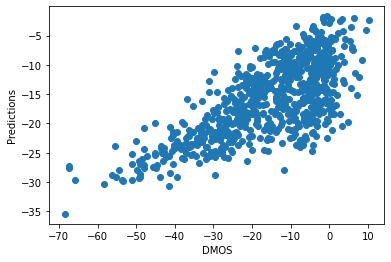

In [10]:
import matplotlib.pyplot as plt

plt.scatter(nscores,npreds)
plt.xlabel('DMOS')
plt.ylabel('Predictions')
plt.show()

In [ ]:
preds_df = 

In [ ]:
def plot_by_fr(col_vals,col_name,codec):
    for val in col_vals:
        hfr_bitrates = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='HFR')& (scores_df['codec']==codec)].bitrate.values
        sfr_bitrates = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='SFR')& (scores_df['codec']==codec)].bitrate.values
        if(len(sfr_bitrates)<6 or len(hfr_bitrates)<6):
            continue
        hfr_scores = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='HFR')& (scores_df['codec']==codec)].dmos.values
        sfr_scores = scores_df[(scores_df[col_name]==val) & (scores_df['fr']=='SFR')& (scores_df['codec']==codec)].dmos.values
        sfr_bitrates,sfr_scores = sort_by_x(sfr_bitrates,sfr_scores)
        hfr_bitrates,hfr_scores = sort_by_x(hfr_bitrates,hfr_scores)
        res_vals = ['288p','396p','396p','540p','540p','720p']
        plt.figure()
        plt.plot(hfr_bitrates,hfr_scores,'g+',color='green',linestyle='dashed')
        #for i,txt in enumerate(res_vals):
        #    plt.annotate(txt, (hfr_bitrates[i], hfr_scores[i]))
        plt.plot(sfr_bitrates,sfr_scores,'r+',color='red',linestyle='dashed')
        #for i,txt in enumerate(res_vals):
        #    plt.annotate(txt, (sfr_bitrates[i], sfr_scores[i]))
        plt.legend(["HEVC HFR","HEVC SFR"])
        plt.xlabel('Bitrate (kbps)')
        plt.ylabel('DMOS')
        plt.title(val)
        plt.savefig('./plots/rawavgmos_HFR_v_SFR_'+codec+'_preds/'+val+'.png')
        plt.close()

In [ ]:
plot_by_fr(content,'content','HEVC')
